# Lab: Explainability in Neural Networks with activation maximization.


------------------------------------------------------
*Alex Guerrero (Lab instructor): alexjorguer@tsc.uc3m.es*

*Alejandro Lancho: alancho@ing.uc3m.es*

*Original material from Pablo M. Olmos*
------------------------------------------------------

In this part of the lab, we will implement a simple example of **activation maximization** to find out wich patterns are neccesary at the input of a neural network, that has been previously trained, to get a desired output (for example, a high confidence in a classification task).

We will visualize this technique using MNIST database.

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'  #To get figures with high quality!

import numpy as np
import torch
from torch import nn
from torch import optim
import matplotlib.pyplot as plt

In [3]:
from IPython.display import Image
from IPython.core.display import HTML 

Image(url= "https://i1.wp.com/datasmarts.net/es/wp-content/uploads/2019/09/1_yBdJCRwIJGoM7pwU-LNW6Q.png?w=479&ssl=1", width=400, height=200)

Load the dataset with torchvision ...

In [4]:
### Run this cell

from torchvision import datasets, transforms

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.,), (1.0,)), # Media 0, varianza 1
                              ])

# Download and load the training  data
trainset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
testset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)


In [5]:
dataiter = iter(trainloader)   # To iterate through the dataset

images, labels = next(dataiter)
print(type(images))
print(images.shape)
print(labels.shape)


<class 'torch.Tensor'>
torch.Size([64, 1, 28, 28])
torch.Size([64])


Let's show some image from that batch ...

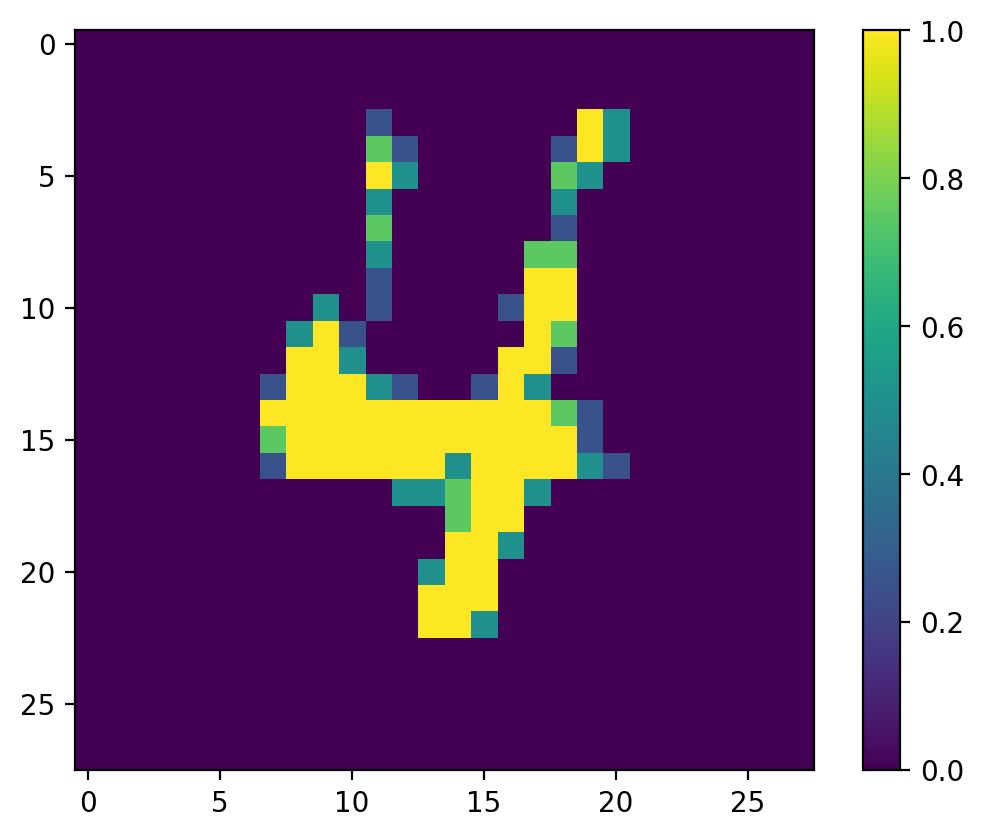

In [6]:
plt.imshow(images[1].numpy().reshape([28,28]), cmap='viridis')
plt.colorbar()

We also create a validation set.

In [7]:
import copy

validloader = copy.deepcopy(trainloader)  # Creates a copy of the object 

#We take the first 45k images for training
trainloader.dataset.data = trainloader.dataset.data[:45000,:,:]
trainloader.dataset.targets = trainloader.dataset.targets[:45000]

#And the rest for validation
validloader.dataset.data = validloader.dataset.data[45000:,:,:]
validloader.dataset.targets = validloader.dataset.targets[45000:]

> **Exercise:** Train an MLP network based on four dense layers of 256, 128, 64 and 10 hidden units respectively. Calculate the accuracy in training and test sets after training only 3 epochs. If you notice overfitting problems, introduce whatever mechanisms you consider to reduce it.

In [8]:
class MLPdrop(nn.Module):
    def __init__(self,dimx,hidden1,hidden2, hidden3, nlabels, dropout): #Nlabels will be 10 in our case
        super().__init__()
        
        self.output1 = nn.Linear(dimx,hidden1)
        
        self.output2 = nn.Linear(hidden1,hidden2)
        
        self.output3 = nn.Linear(hidden2,hidden3)

        self.output4 = nn.Linear(hidden3,nlabels)

        self.relu = nn.ReLU()
        
        self.logsoftmax = nn.LogSoftmax(dim=1) 
        # Dropout module with 0.2 drop probability
        self.dropout = nn.Dropout(dropout)                                                            
        
    def forward(self, x):
        # Pass the input tensor through each of our operations
        x = self.output1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.output2(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.output3(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.output4(x)
        x = self.logsoftmax(x)
        return x

In [9]:
class MLPdrop_extended(MLPdrop):
    #YOUR CODE HERE
    def __init__(self, dimx, hidden1, hidden2, hidden3, nlabels, epochs=100, lr=0.001, dropout=0.2):
        super().__init__(dimx, hidden1, hidden2, hidden3, nlabels, dropout=dropout)
        self.lr = lr
        self.optim = optim.Adam(self.parameters(), self.lr)
        self.epochs = epochs
        self.criterion = nn.NLLLoss()
        self.loss_during_training = []
        self.valid_loss_during_training = [] 

    def trainloop(self, trainloader, validloader):
        for e in range(int(self.epochs)):
            running_loss = 0
            self.train()
            
            for images, labels in trainloader:
                self.optim.zero_grad()
                out = self.forward(images.view(images.shape[0], -1))
                loss = self.criterion(out, labels)
                running_loss += loss.item()
                loss.backward()
                self.optim.step()

            self.loss_during_training.append(running_loss / len(trainloader))
            
            valid_loss = 0 
            with torch.no_grad():
                self.eval()  
                
                for images, labels in validloader:
                    out = self.forward(images.view(images.shape[0], -1))
                    loss = self.criterion(out, labels)
                    valid_loss += loss.item()
            self.valid_loss_during_training.append(valid_loss / len(validloader))

            print(f"Epoch {e + 1}/{self.epochs}.. "
                  f"Training loss: {self.loss_during_training[-1]:.3f}.. "
                  f"Validation loss: {self.valid_loss_during_training[-1]:.3f}")

    def evaluate(self, dataloader):
        accuracy = 0
        
        with torch.no_grad():
            self.eval()  
            
            for images, labels in dataloader:
                logprobs = self.forward(images.view(images.shape[0], -1))
                top_p, top_class = logprobs.topk(1, dim=1)
                equals = (top_class == labels.view(images.shape[0], 1))
                accuracy += torch.mean(equals.type(torch.FloatTensor))
        print(f"Accuracy: {accuracy / len(dataloader):.3f}")

In [10]:
my_MLPdrop_extended = MLPdrop_extended( dimx=784, hidden1=256, hidden2=128, hidden3=64, nlabels=10, epochs=3, lr=0.001, dropout=0.2)
my_MLPdrop_extended.trainloop(trainloader,validloader)
my_MLPdrop_extended.evaluate(trainloader)
my_MLPdrop_extended.evaluate(testloader)

Epoch 1/3.. Training loss: 0.436.. Validation loss: 0.173
Epoch 2/3.. Training loss: 0.173.. Validation loss: 0.120
Epoch 3/3.. Training loss: 0.124.. Validation loss: 0.108
Accuracy: 0.981
Accuracy: 0.972


## Activation Maximization

Once our network has been trained, the goal is to find which features at the input of the network (pixels in our case) are more important for the classifier to decide one class or another at the output. That is, choose between one digit or another at the output. 

The steps we follow are the following:

- We fix the parameters that we have just trained.

- We define a new set of trainable parameters that will emulate the input of the network and we will opbtimize to have a high confidence in a specific digit.

We implement the first step with the following code:

In [11]:
for param in my_MLPdrop_extended.parameters(): #my_MLP_drop is the name of your neural network!
    param.requires_grad = False

> **Exercise:** Complete the following code, in which we define the optimization problem to find the image at the input of the network that provides a given confidence in a given digit

In [12]:
class Optimize_NN_Input(nn.Module):

    def __init__(self,NN_trained,lr,img0): 
      
        # NN_trained is the trained network, as argument

        # img0 is a radomn initialization for the input image
        
        super().__init__()
        
        # Self.input --> Image to be optimized

        self.input = nn.Parameter(img0.reshape([1,-1]),requires_grad = True)

        self.NN_trained = NN_trained

        self.img0 = img0

        self.lr = lr
        
        # We use mean squared error to minimize the difference between the desired probability and the 
        # obtained for self.input to input

        self.criterion = nn.MSELoss() 

        self.optim = optim.Adam(self.parameters(), self.lr)

        self.loss_during_training = []

    def forward(self):

        # In the forward method we only evaluate the log-probabilities given self.input!

        logprobs = self.NN_trained(self.input.view(1, -1))
        
        return logprobs

    def trainloop(self,category,true_prob,sgd_iter):

        # Category is the digit we are going to look at

        # true_prob is the desired probability, which we pass to logarithm
        
        true_log_prob = torch.log(true_prob)

        # sgd_iter is the number of iterations
        running_loss = 0
        for i in range(sgd_iter):

            # Reset the gradients
            #YOUR CODE HERE 
            self.optim.zero_grad()
            # Compute the network output
            #YOUR CODE HERE
            logprobs = self.NN_trained.forward(self.input)

            # We calculate the difference between the desired probability (true_log_prob) and the obtained one
            # for the digit
            
            loss = self.criterion(logprobs[0,category].view(true_log_prob.shape),true_log_prob)
            running_loss += loss.item()

            self.loss_during_training.append(loss)

            # Compute gradients
            loss.backward()
          
            # Optimize
            self.optim.step()

Let's instanciate an object of the previous class for a random initialization (independent Gaussian distribution with mean zero and standard deviation 0.01)

In [13]:
opt_input = Optimize_NN_Input(NN_trained=my_MLPdrop_extended,lr=5e-3,img0=torch.randn(28,28)*0.01)

> **Exercise:** Obtain the probability distribution at the output of the classifier for the chosen initialization. Remember that the classifier uses a `logsoftmax` on output. Discuss the result.

In [14]:
logprobs = opt_input.forward()
probs = torch.exp(logprobs)
print(probs)

tensor([[0.0755, 0.0958, 0.0515, 0.0892, 0.0878, 0.2476, 0.0792, 0.0999, 0.0723,
         0.1011]], grad_fn=<ExpBackward0>)


> **Exercise:**: Optimize the input representation for 50 iterations to obtain 90% confidence in the digit 3. Plot the loss function.

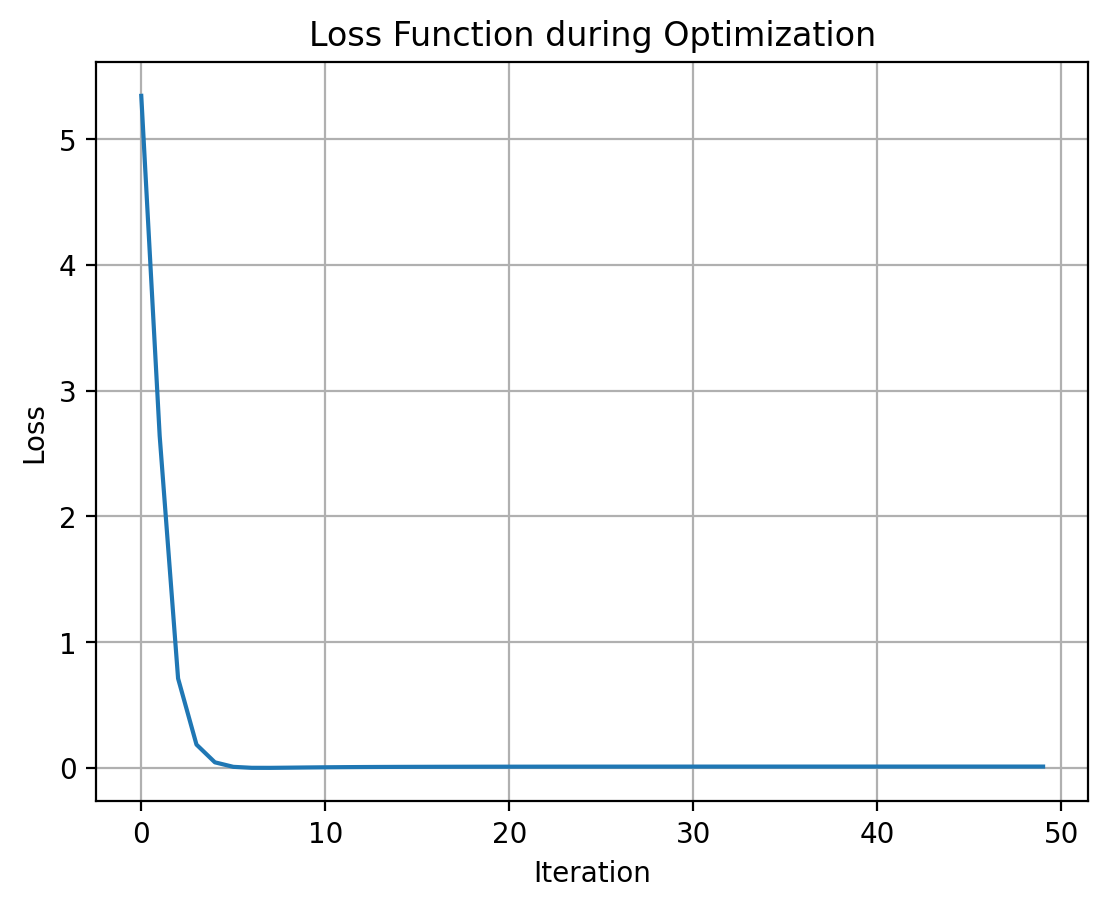

In [15]:
#YOUR CODE HERE
opt_input.trainloop(category=3, true_prob=torch.tensor(0.9), sgd_iter=50)

plt.plot([loss.item() for loss in opt_input.loss_during_training], label='Training Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Loss Function during Optimization')
plt.grid(True)
plt.show()

> **Exercise:** Compare the probabilities at the output of the classifier before and after optimizing at the input

tensor([[6.4454e-07, 2.4646e-04, 8.6494e-04, 9.9673e-01, 1.1786e-06, 1.2895e-03,
         1.2613e-08, 5.7520e-04, 1.2141e-04, 1.6998e-04]])


Text(0.5, 1.0, 'Probabilities After Optimization')

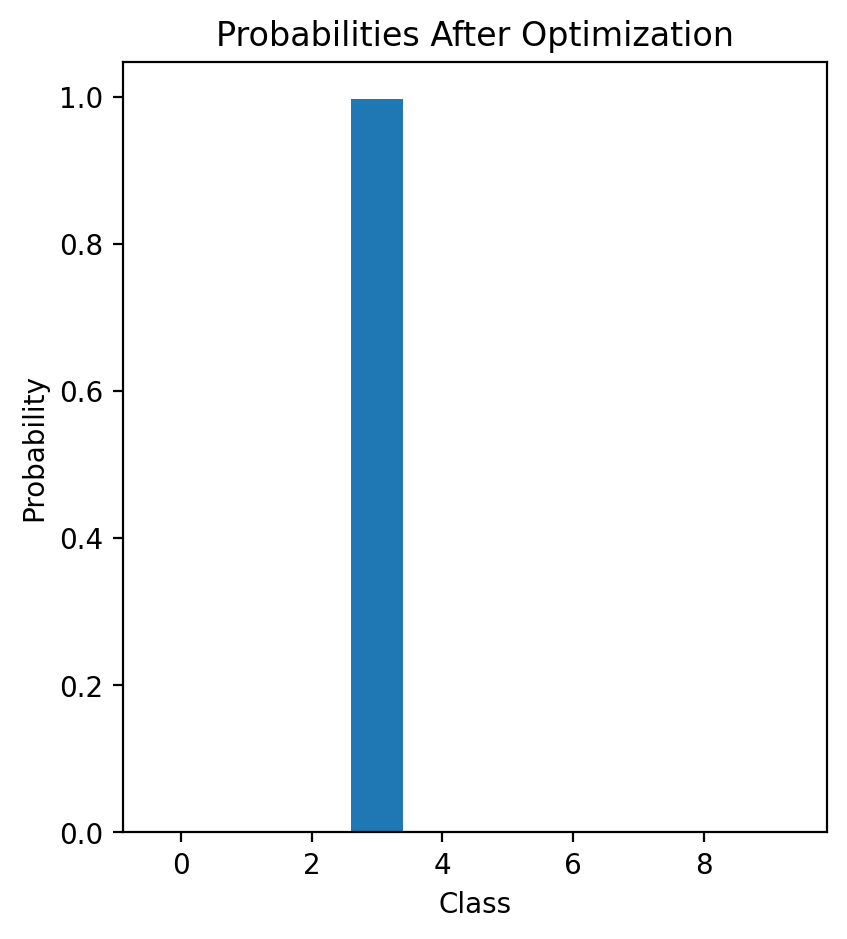

In [16]:
#YOUR CODE HERE
logprobs_after = opt_input.forward()
probs_after = torch.exp(logprobs_after).detach()
print(probs_after)

# 4. Plot the probabilities before and after optimization
plt.figure(figsize=(10, 5))

# Plot after optimization
plt.subplot(1, 2, 2)
plt.bar(range(probs_after.shape[1]), probs_after.squeeze().cpu().numpy())
plt.xlabel('Class')
plt.ylabel('Probability')
plt.title('Probabilities After Optimization')

> **Exercise:** Display the optimized input image. Does it roughly match the expected digit? Discuss the results.

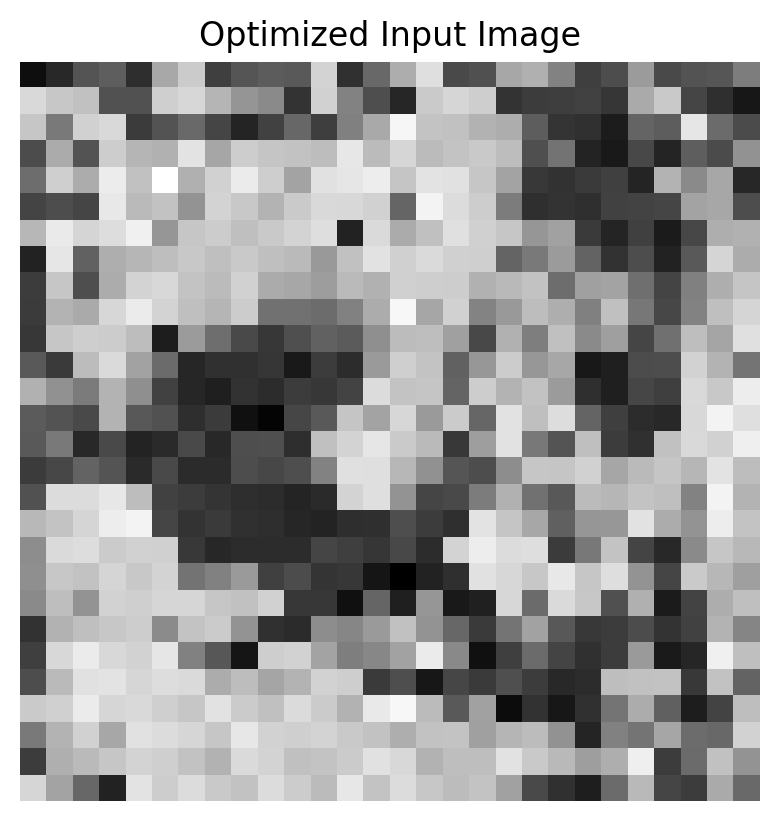

In [17]:
#YOUR CODE HERE
optimized_image = opt_input.input.detach().reshape(28, 28).cpu().numpy()

plt.figure()
plt.imshow(optimized_image, cmap='gray')
plt.title('Optimized Input Image')
plt.axis('off')
plt.show()

> **Exercise:** Repeat the results for all digits and discuss those results.

Optimizing for category 0...
Probabilities before optimization for category 0:
tensor([[0.0821, 0.1021, 0.0763, 0.0816, 0.1178, 0.1721, 0.0890, 0.1276, 0.0668,
         0.0846]], grad_fn=<ExpBackward0>)


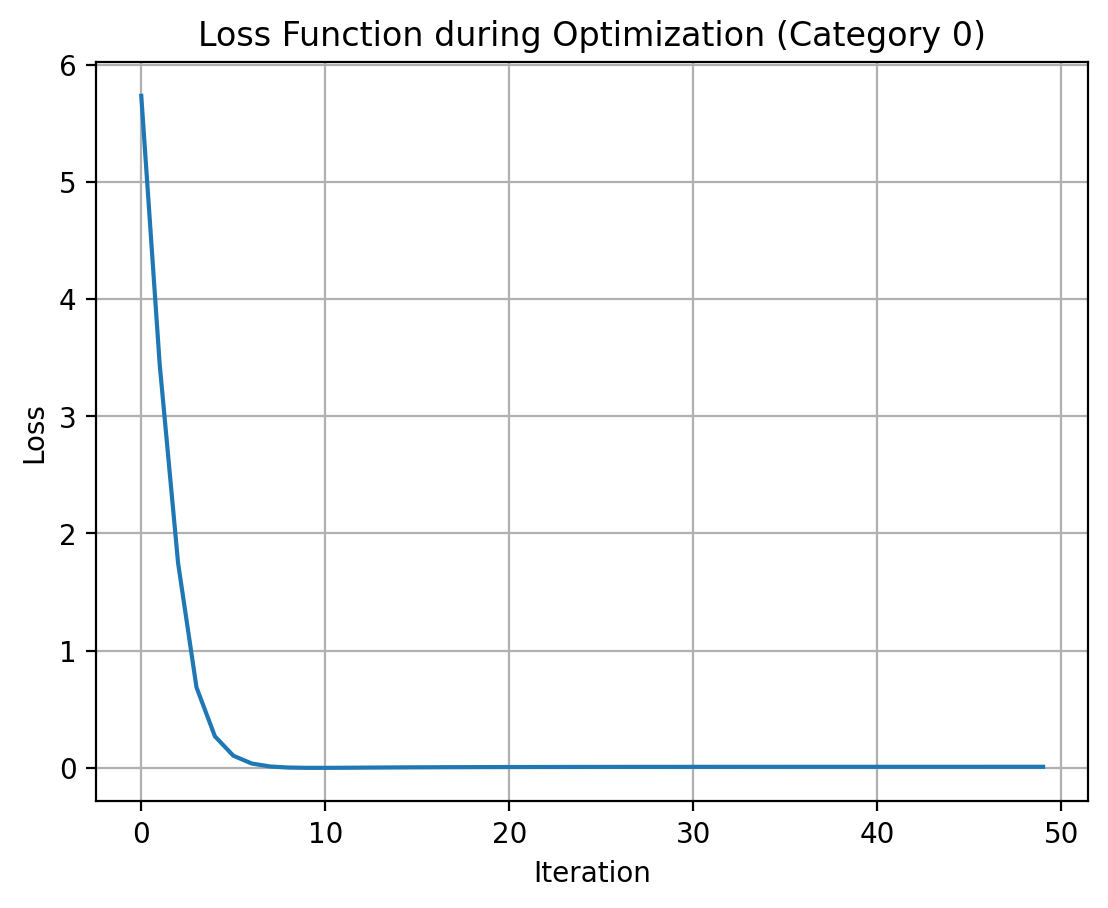

Probabilities after optimization for category 0:
tensor([[9.9066e-01, 1.4836e-04, 1.9248e-03, 5.9171e-04, 2.4531e-04, 8.3439e-04,
         1.4841e-03, 1.8531e-03, 6.0827e-04, 1.6496e-03]])


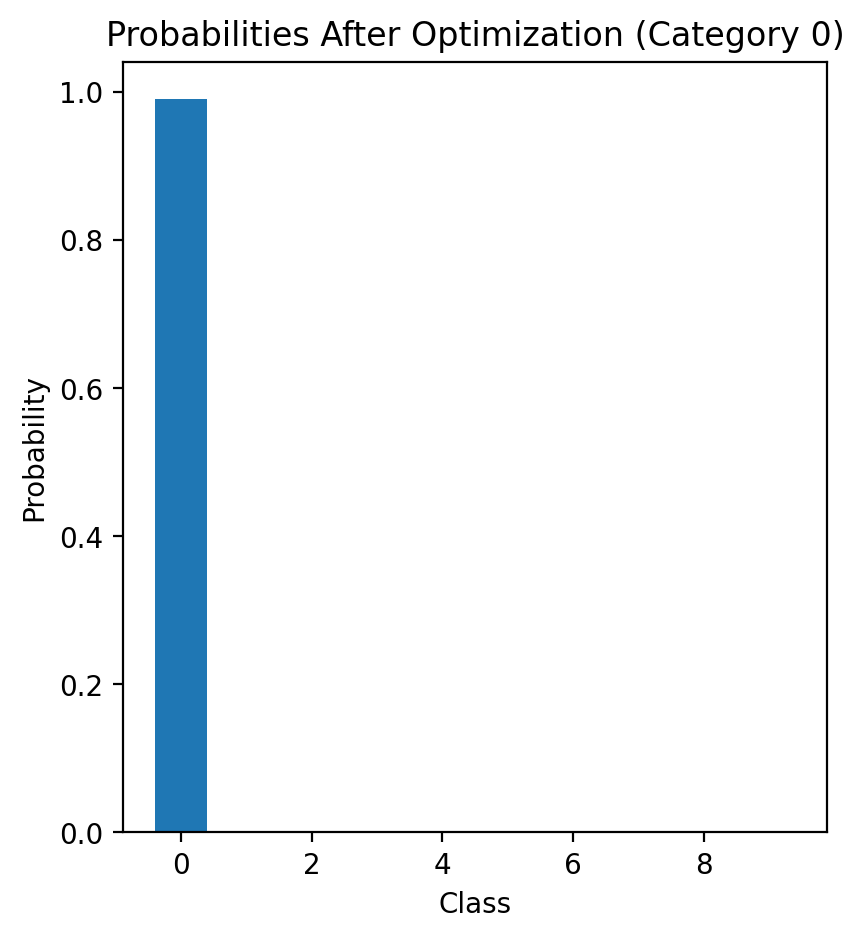

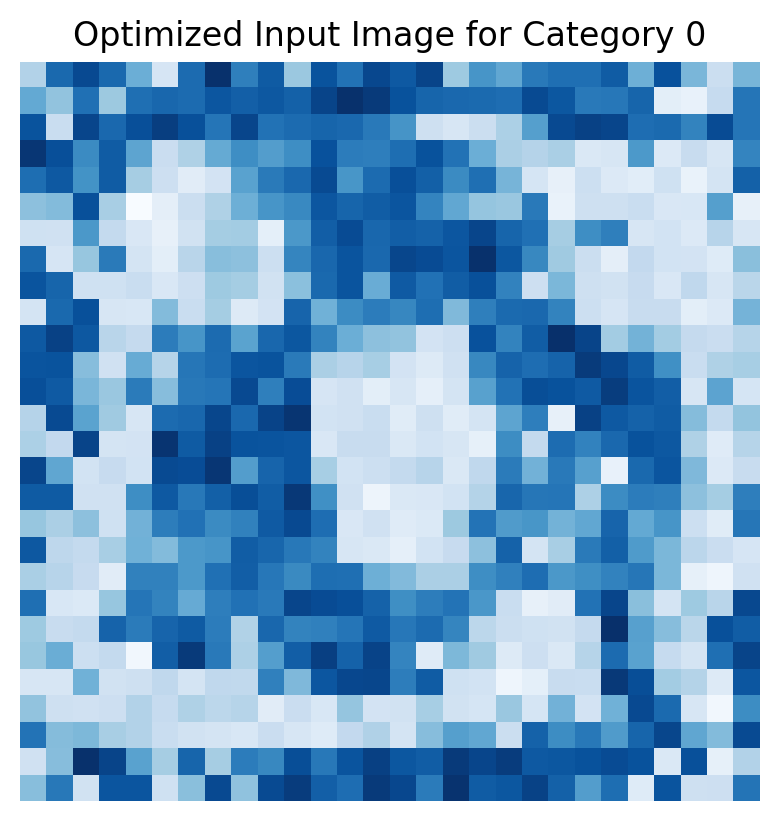

Finished optimization for category 0


Optimizing for category 1...
Probabilities before optimization for category 1:
tensor([[0.0768, 0.1051, 0.0834, 0.0746, 0.1339, 0.1637, 0.0984, 0.1204, 0.0696,
         0.0742]], grad_fn=<ExpBackward0>)


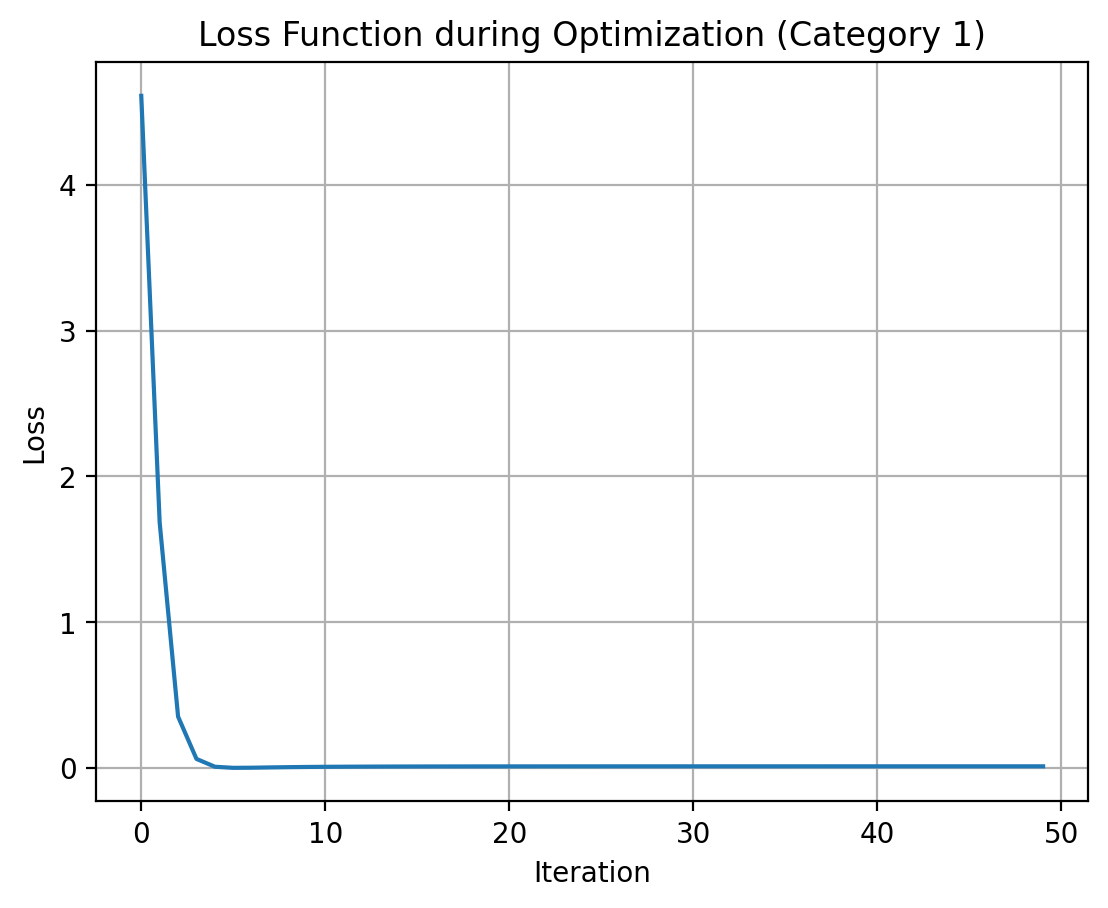

Probabilities after optimization for category 1:
tensor([[3.7481e-06, 9.9753e-01, 1.7418e-03, 2.3943e-04, 9.3506e-06, 2.1209e-05,
         7.6666e-05, 3.2772e-04, 4.3862e-05, 1.4889e-06]])


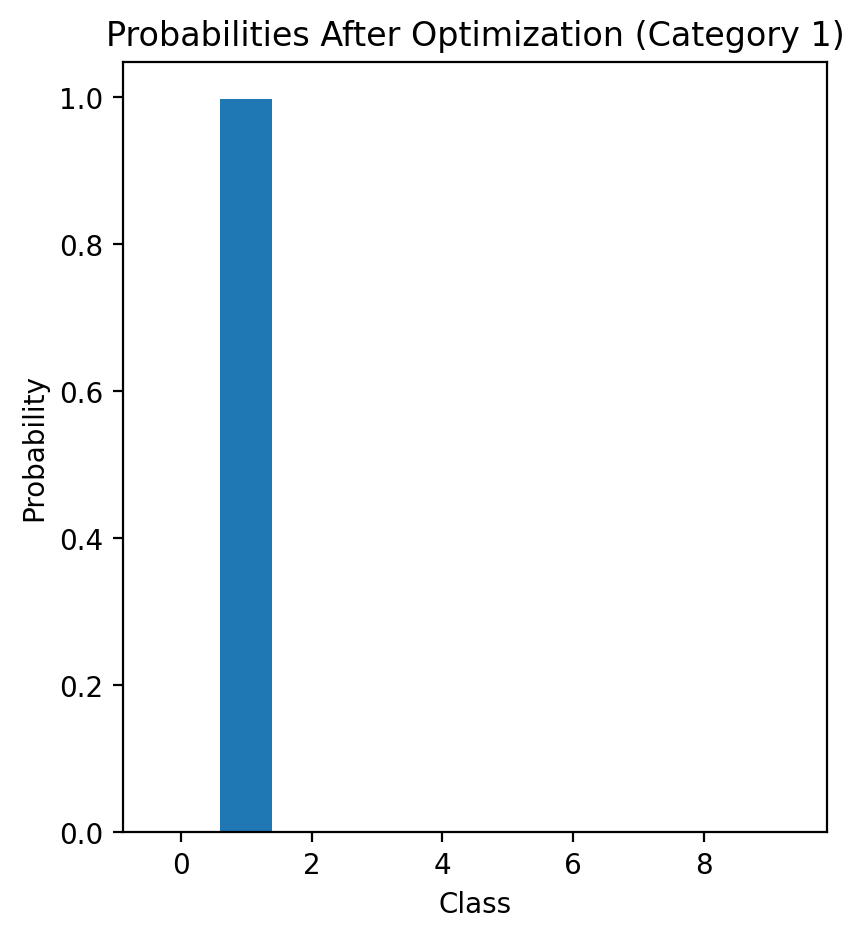

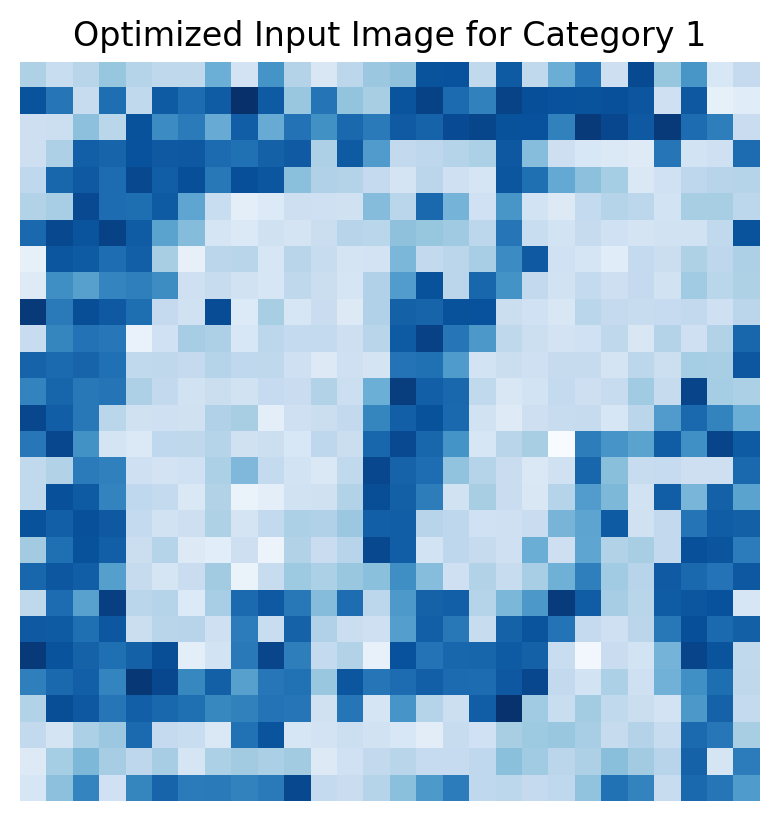

Finished optimization for category 1


Optimizing for category 2...
Probabilities before optimization for category 2:
tensor([[0.0649, 0.1067, 0.0646, 0.0750, 0.1470, 0.1563, 0.0676, 0.1530, 0.0596,
         0.1051]], grad_fn=<ExpBackward0>)


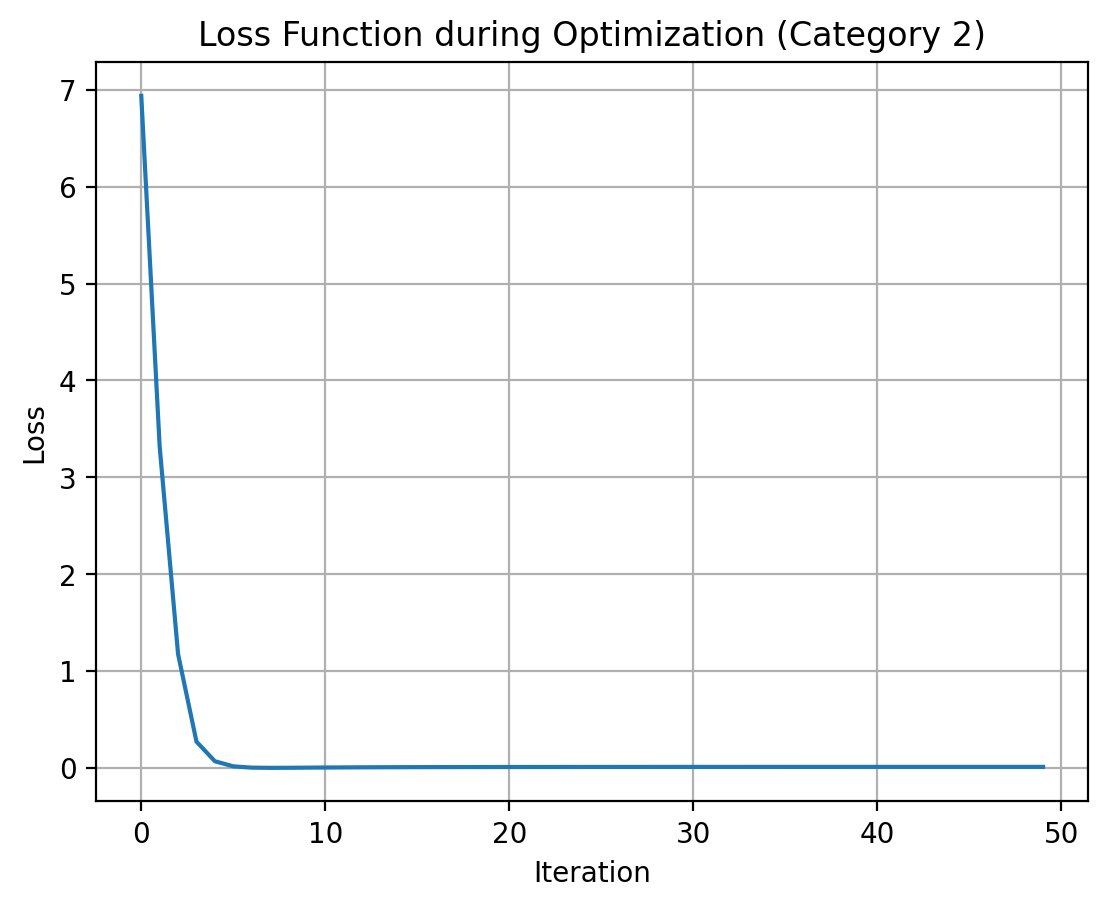

Probabilities after optimization for category 2:
tensor([[1.5726e-05, 1.4104e-03, 9.9476e-01, 2.4252e-03, 3.2035e-05, 3.9470e-05,
         1.8239e-05, 1.2279e-03, 6.6342e-05, 5.7719e-07]])


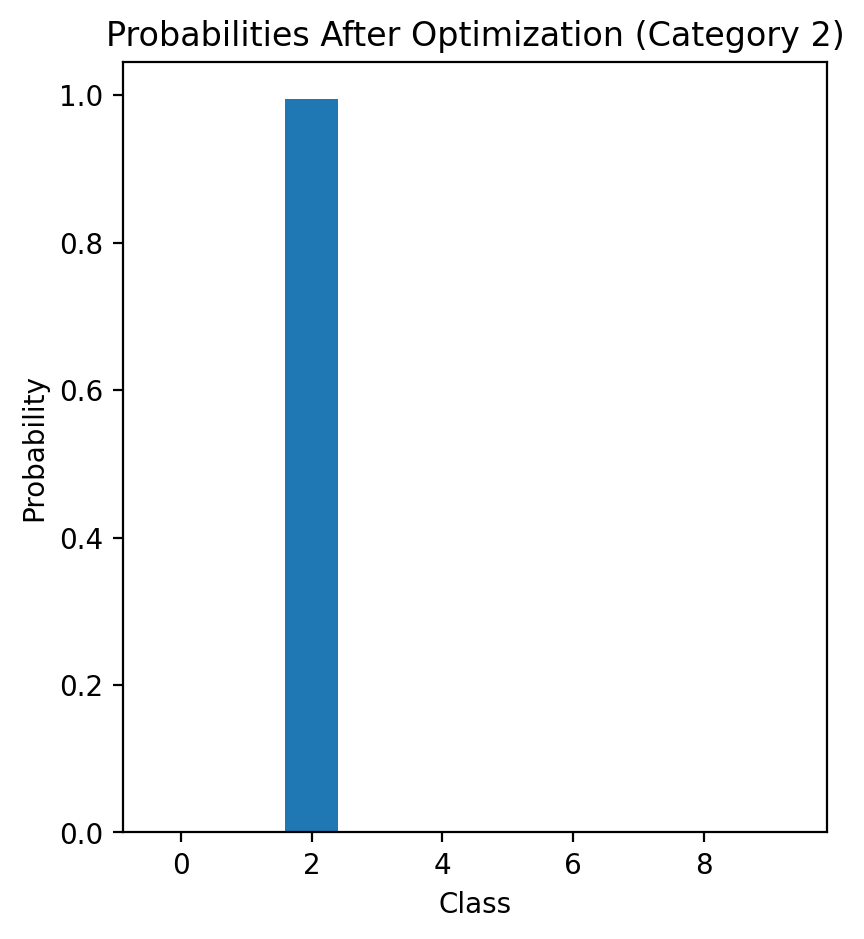

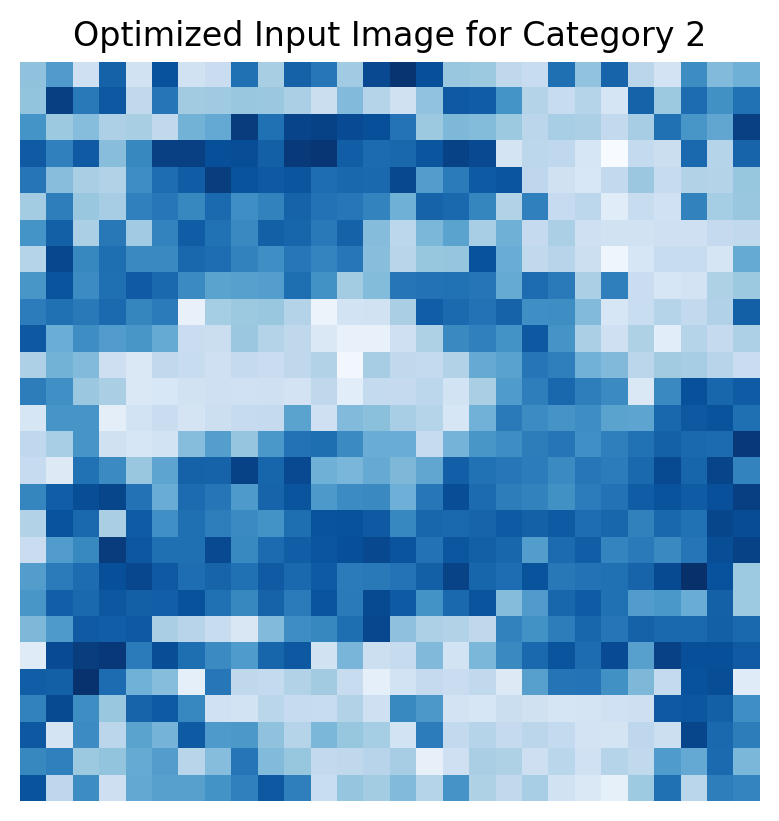

Finished optimization for category 2


Optimizing for category 3...
Probabilities before optimization for category 3:
tensor([[0.0740, 0.1205, 0.0791, 0.0781, 0.1250, 0.1640, 0.0926, 0.1218, 0.0670,
         0.0779]], grad_fn=<ExpBackward0>)


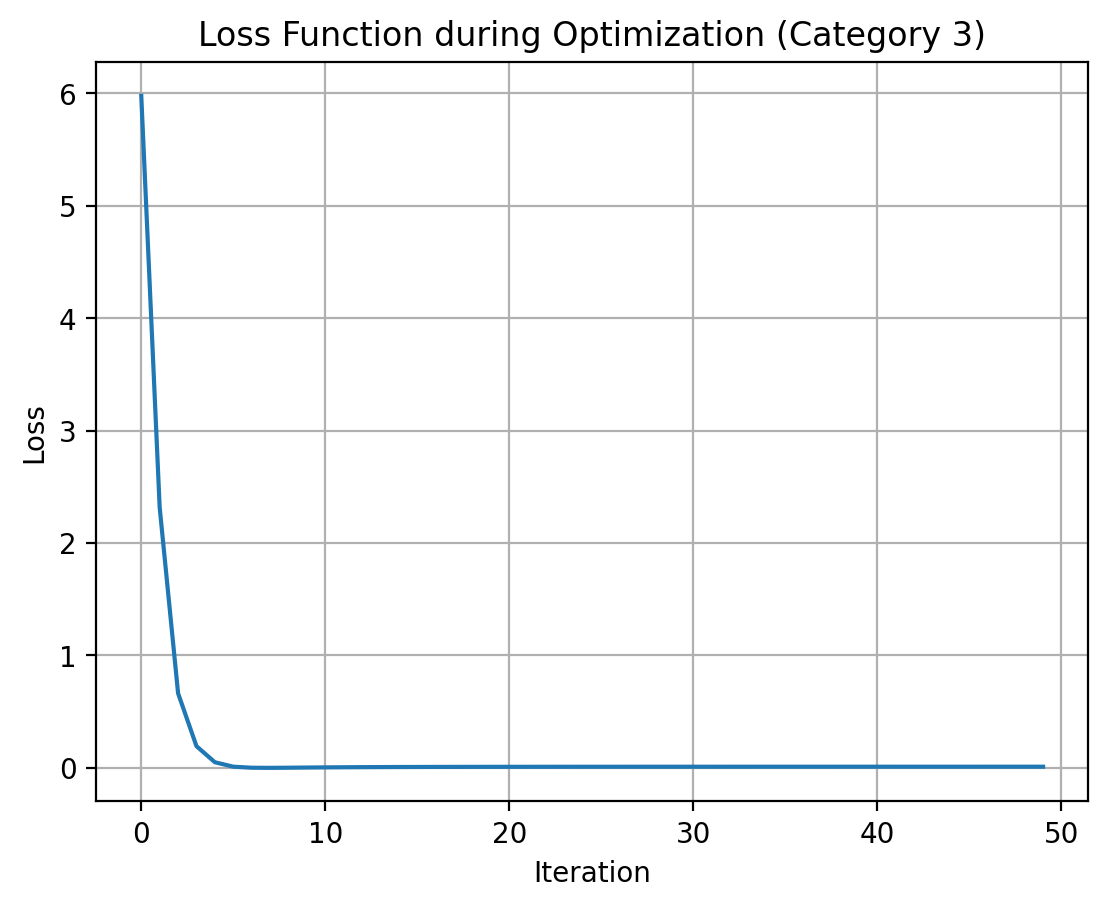

Probabilities after optimization for category 3:
tensor([[6.5132e-07, 3.8051e-04, 1.2354e-03, 9.9606e-01, 1.0054e-06, 1.7464e-03,
         2.1307e-08, 3.7833e-04, 1.0106e-04, 9.9479e-05]])


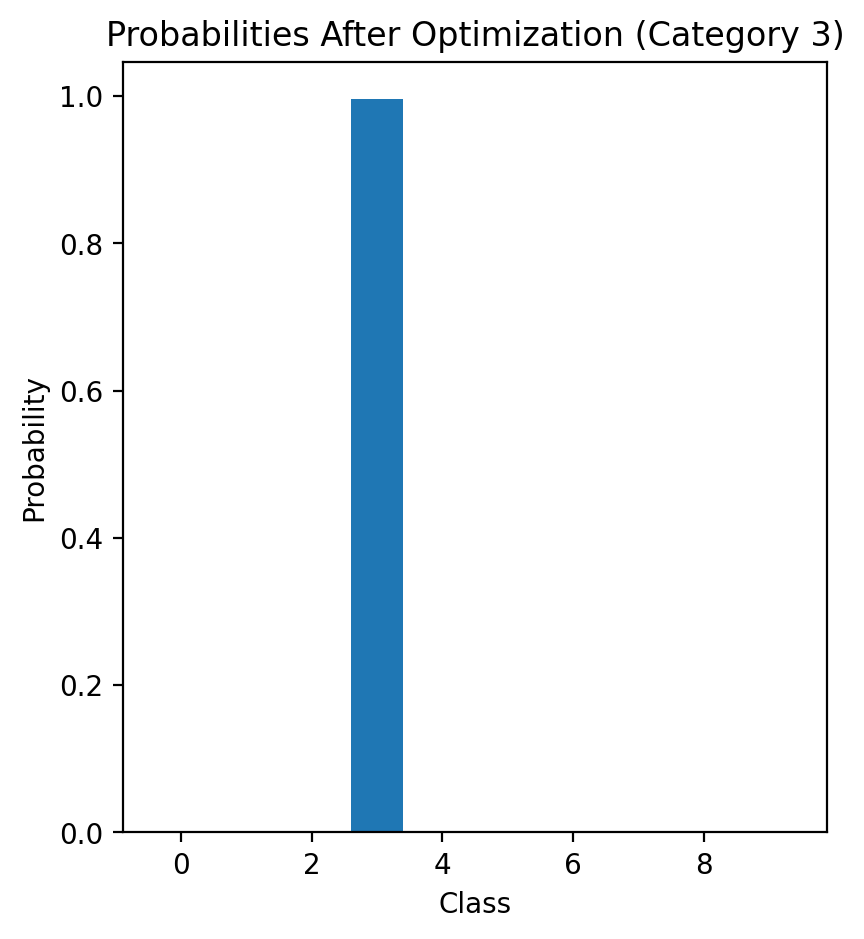

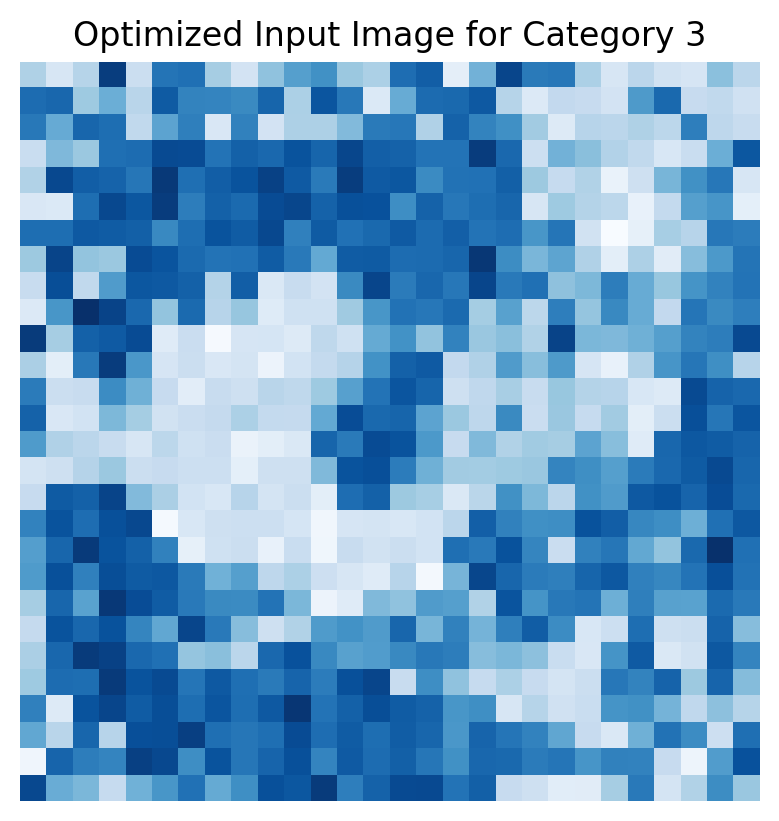

Finished optimization for category 3


Optimizing for category 4...
Probabilities before optimization for category 4:
tensor([[0.0680, 0.1077, 0.0690, 0.0800, 0.1293, 0.1921, 0.0828, 0.1154, 0.0681,
         0.0875]], grad_fn=<ExpBackward0>)


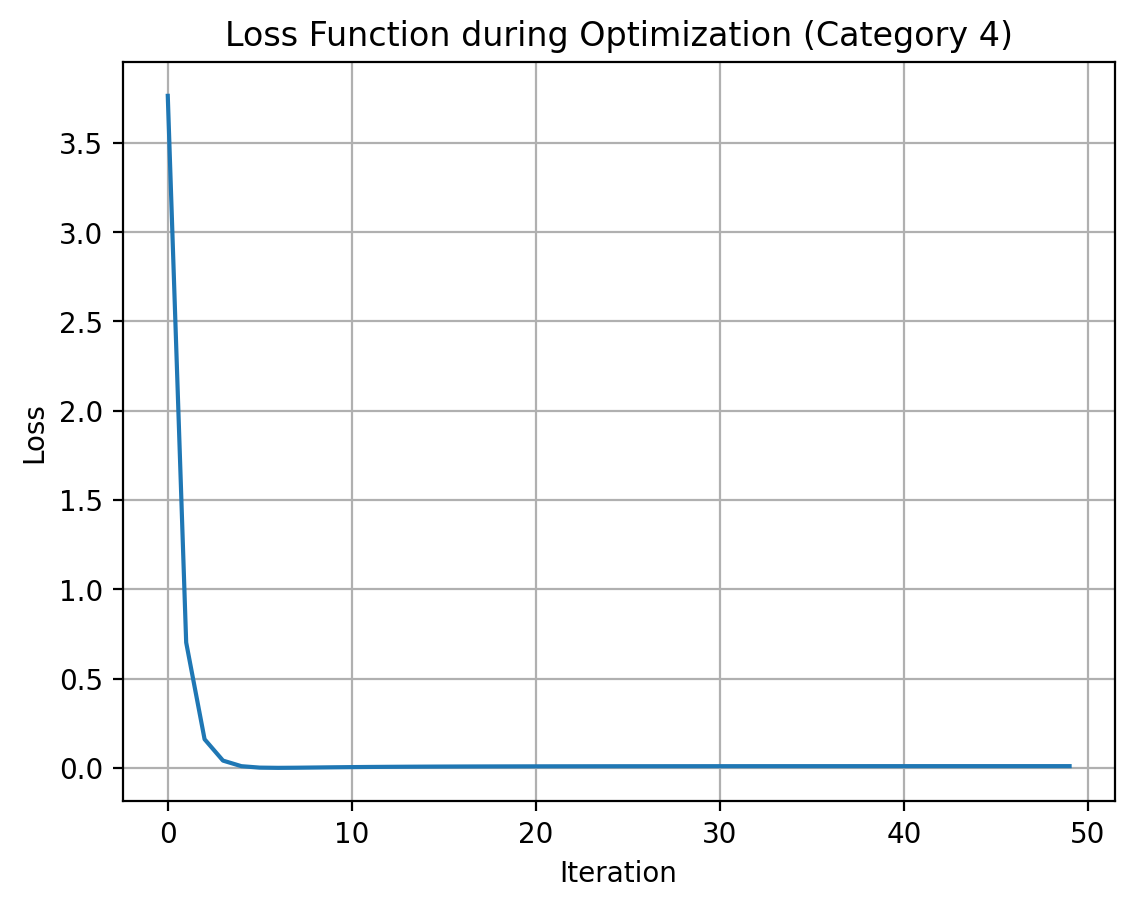

Probabilities after optimization for category 4:
tensor([[5.8790e-05, 4.6170e-04, 1.2136e-03, 2.5181e-05, 9.9248e-01, 8.3302e-05,
         8.1914e-04, 2.5462e-03, 2.6080e-04, 2.0514e-03]])


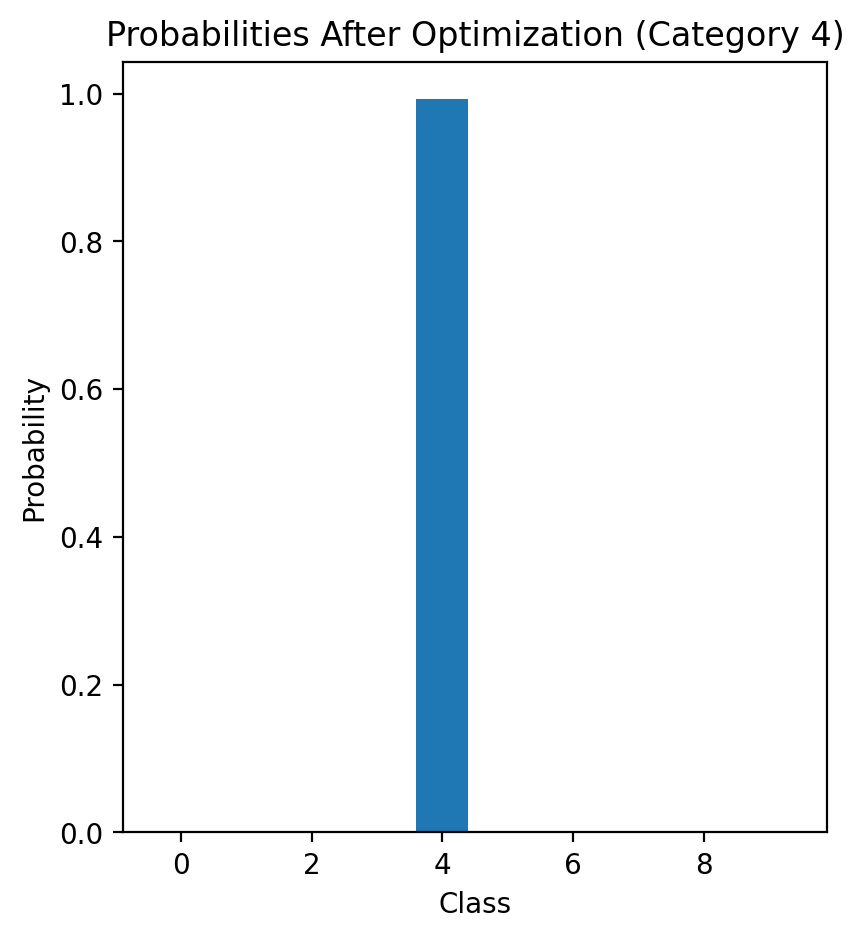

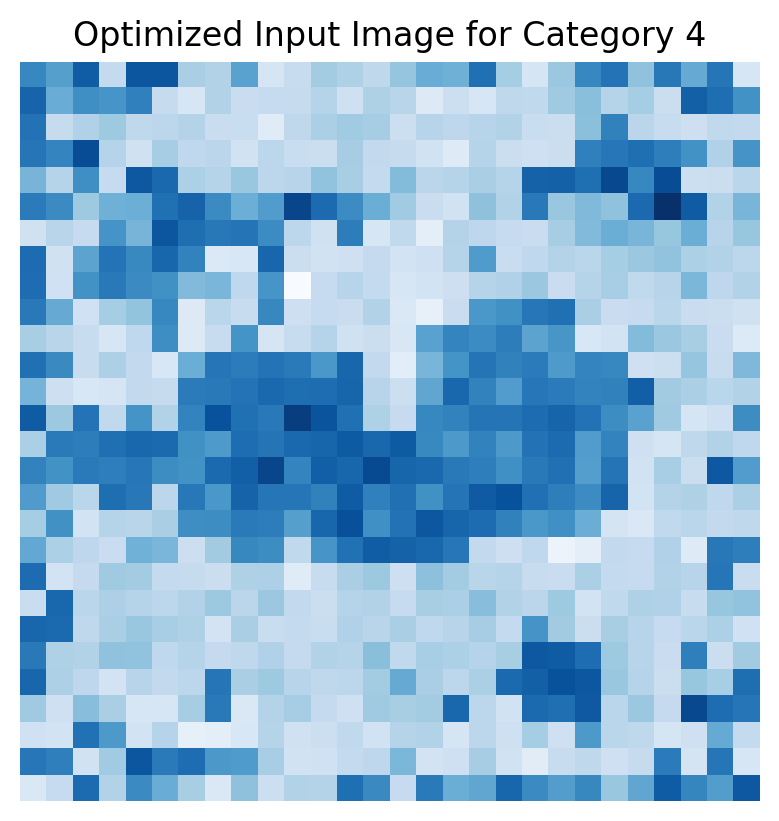

Finished optimization for category 4


Optimizing for category 5...
Probabilities before optimization for category 5:
tensor([[0.0733, 0.1210, 0.0785, 0.0750, 0.1237, 0.1583, 0.0838, 0.1392, 0.0666,
         0.0806]], grad_fn=<ExpBackward0>)


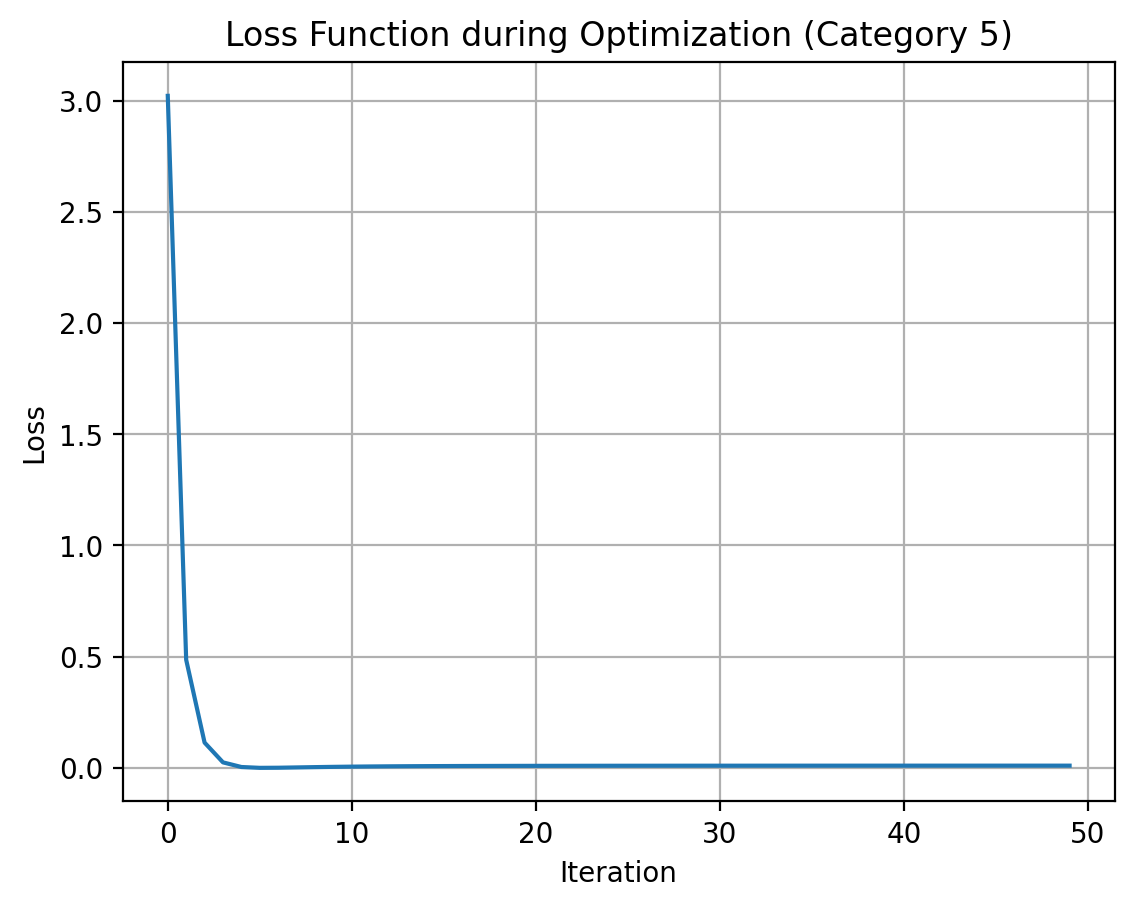

Probabilities after optimization for category 5:
tensor([[4.4009e-05, 9.1734e-05, 8.0032e-06, 3.0426e-03, 2.0712e-05, 9.9437e-01,
         2.5971e-04, 1.4732e-05, 1.4041e-03, 7.4280e-04]])


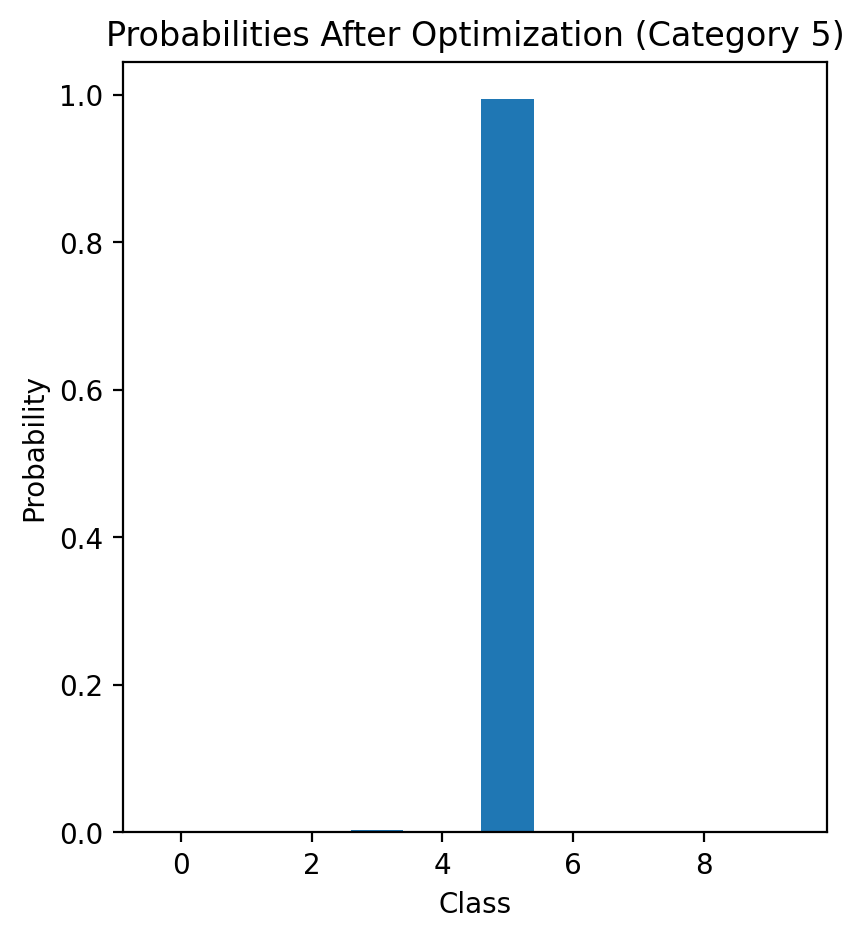

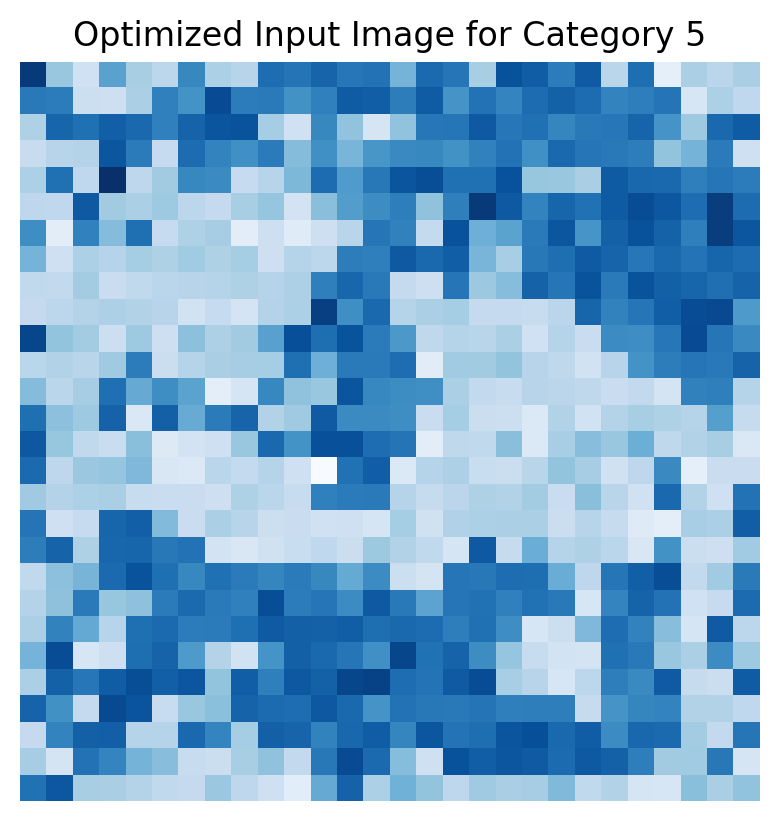

Finished optimization for category 5


Optimizing for category 6...
Probabilities before optimization for category 6:
tensor([[0.0825, 0.0857, 0.0629, 0.0798, 0.1121, 0.1961, 0.0864, 0.1130, 0.0787,
         0.1027]], grad_fn=<ExpBackward0>)


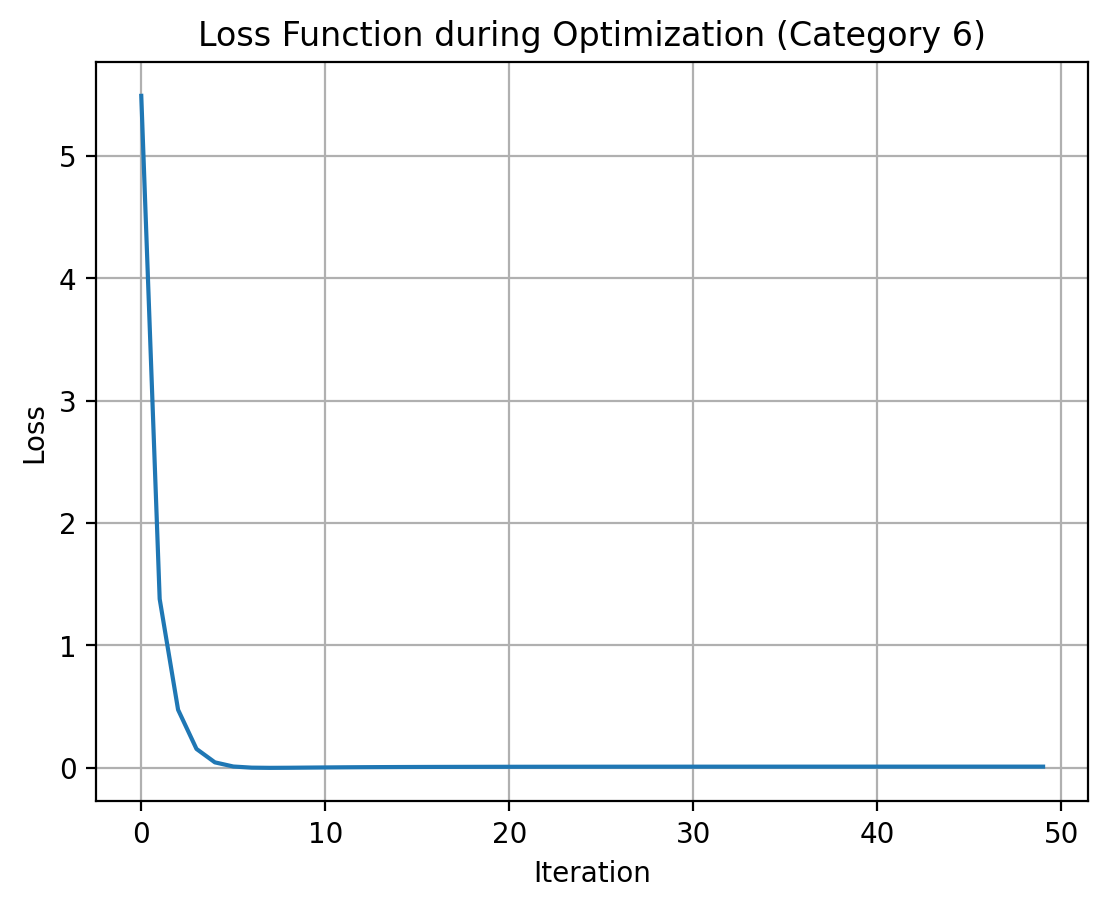

Probabilities after optimization for category 6:
tensor([[5.9209e-04, 3.1249e-04, 4.0280e-04, 3.5156e-05, 2.4405e-03, 1.2689e-03,
         9.9413e-01, 4.7980e-05, 7.6273e-04, 9.2099e-06]])


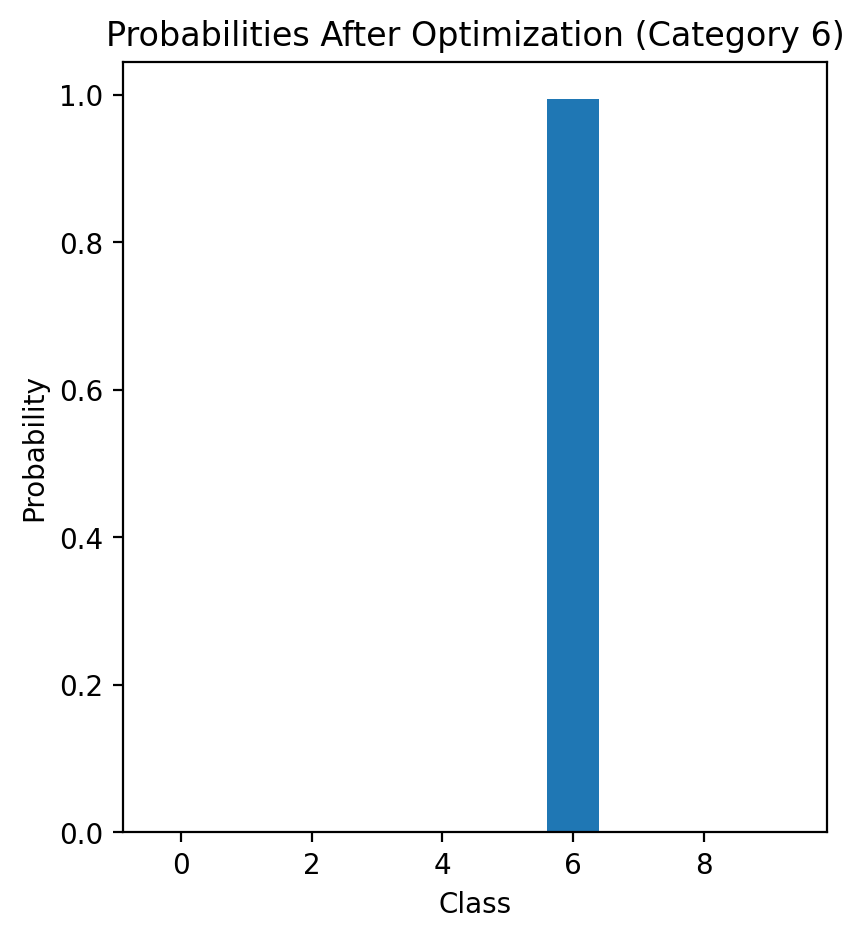

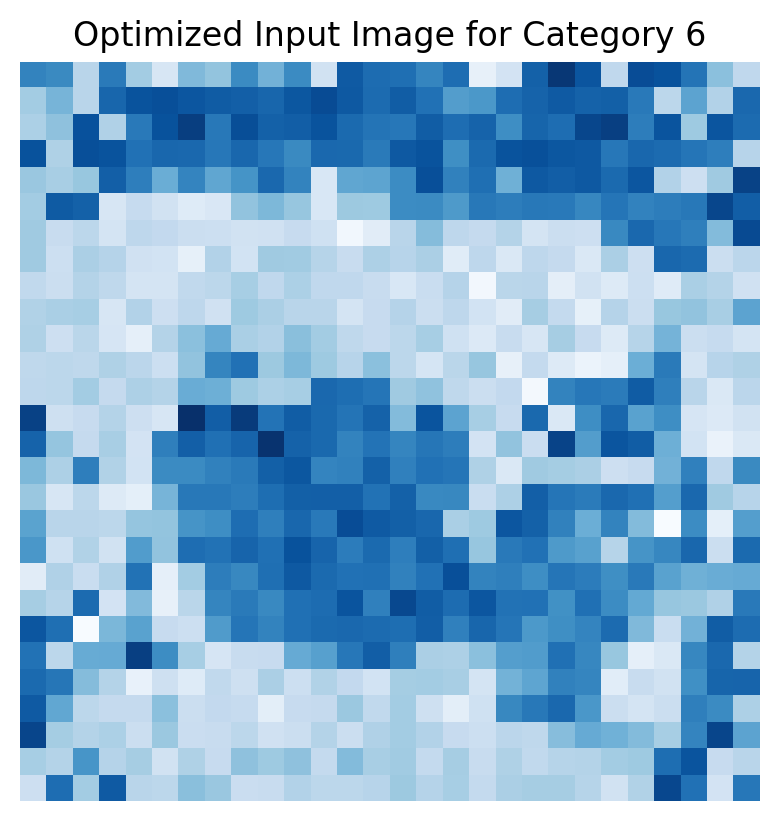

Finished optimization for category 6


Optimizing for category 7...
Probabilities before optimization for category 7:
tensor([[0.0751, 0.1115, 0.0759, 0.0692, 0.1400, 0.1618, 0.1138, 0.1016, 0.0736,
         0.0776]], grad_fn=<ExpBackward0>)


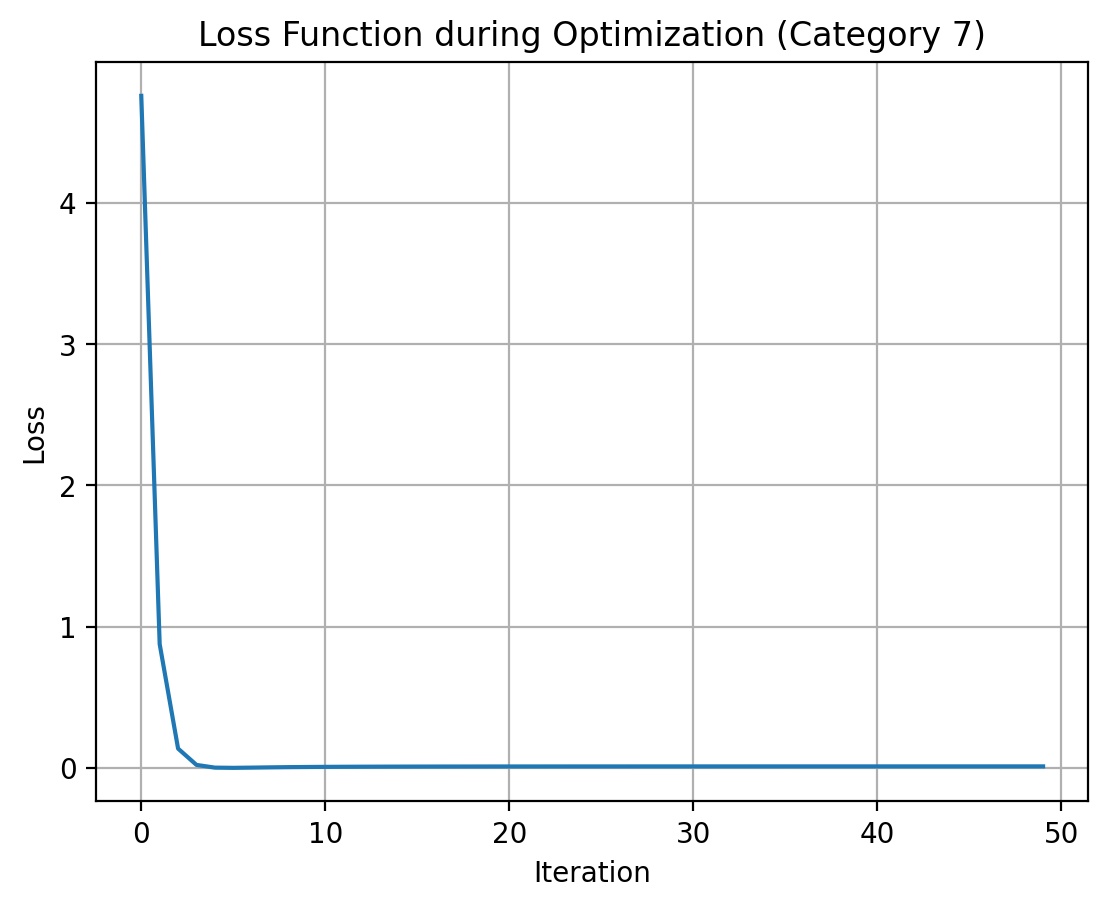

Probabilities after optimization for category 7:
tensor([[1.5602e-05, 1.2981e-04, 1.6506e-04, 2.7297e-04, 4.8527e-05, 5.8241e-06,
         4.2530e-09, 9.9719e-01, 1.4868e-06, 2.1740e-03]])


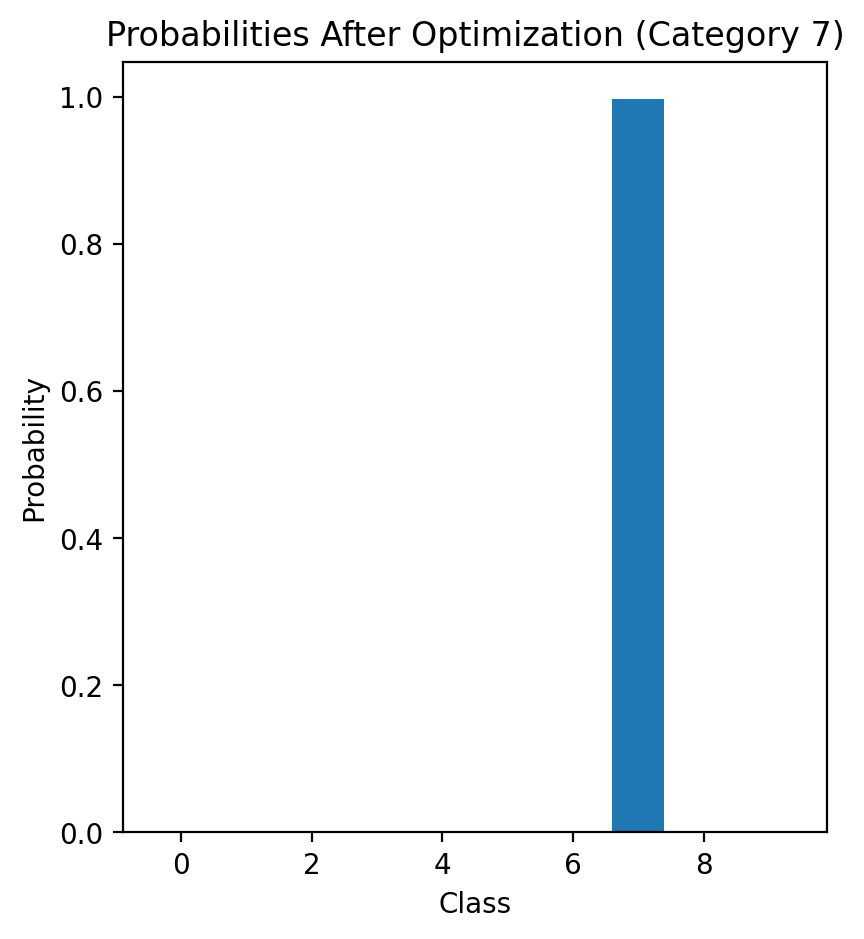

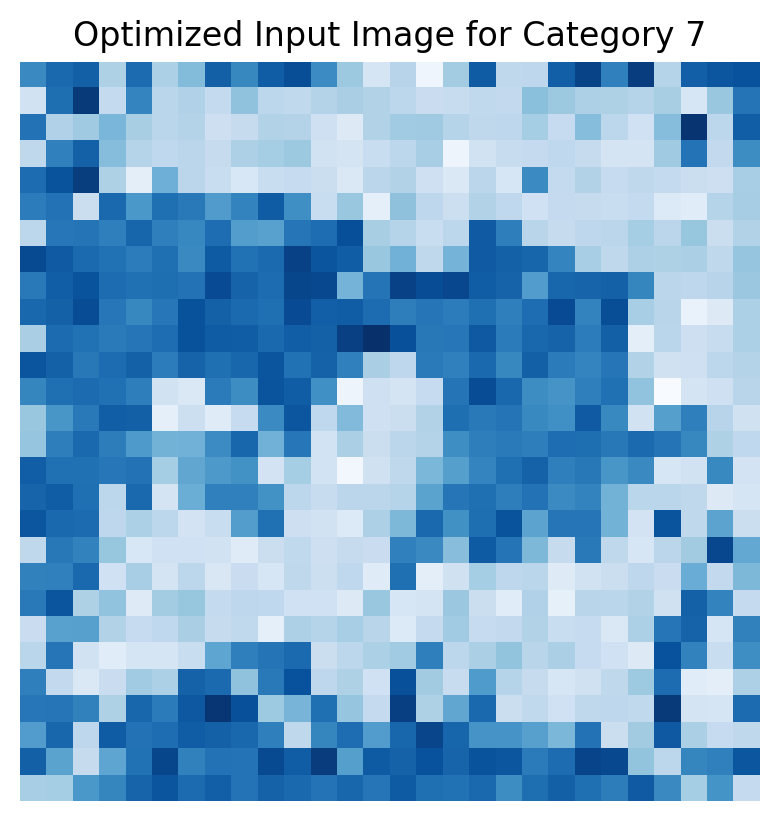

Finished optimization for category 7


Optimizing for category 8...
Probabilities before optimization for category 8:
tensor([[0.0712, 0.0987, 0.0709, 0.0638, 0.1771, 0.1370, 0.0915, 0.1275, 0.0652,
         0.0971]], grad_fn=<ExpBackward0>)


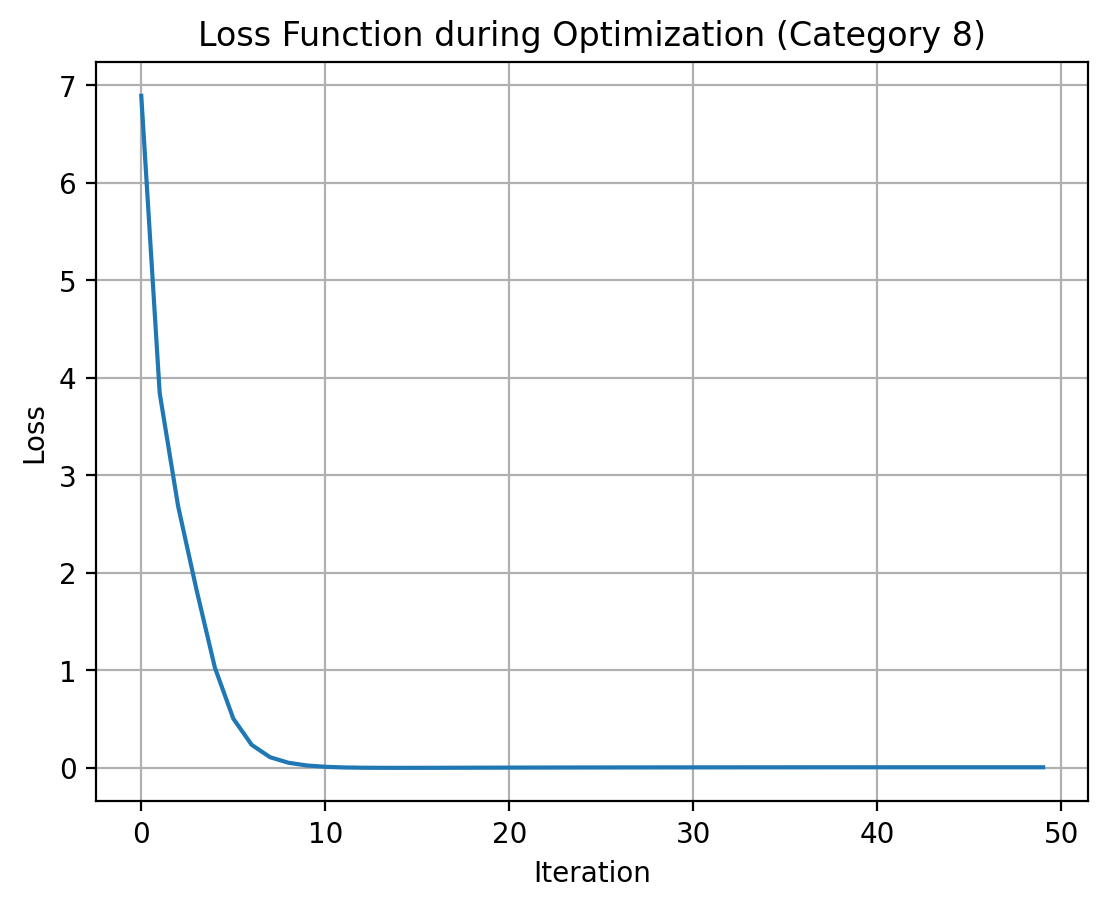

Probabilities after optimization for category 8:
tensor([[7.1196e-04, 2.8119e-03, 9.1485e-03, 4.3829e-03, 9.6689e-04, 5.8770e-03,
         2.2116e-03, 4.0591e-04, 9.7223e-01, 1.2555e-03]])


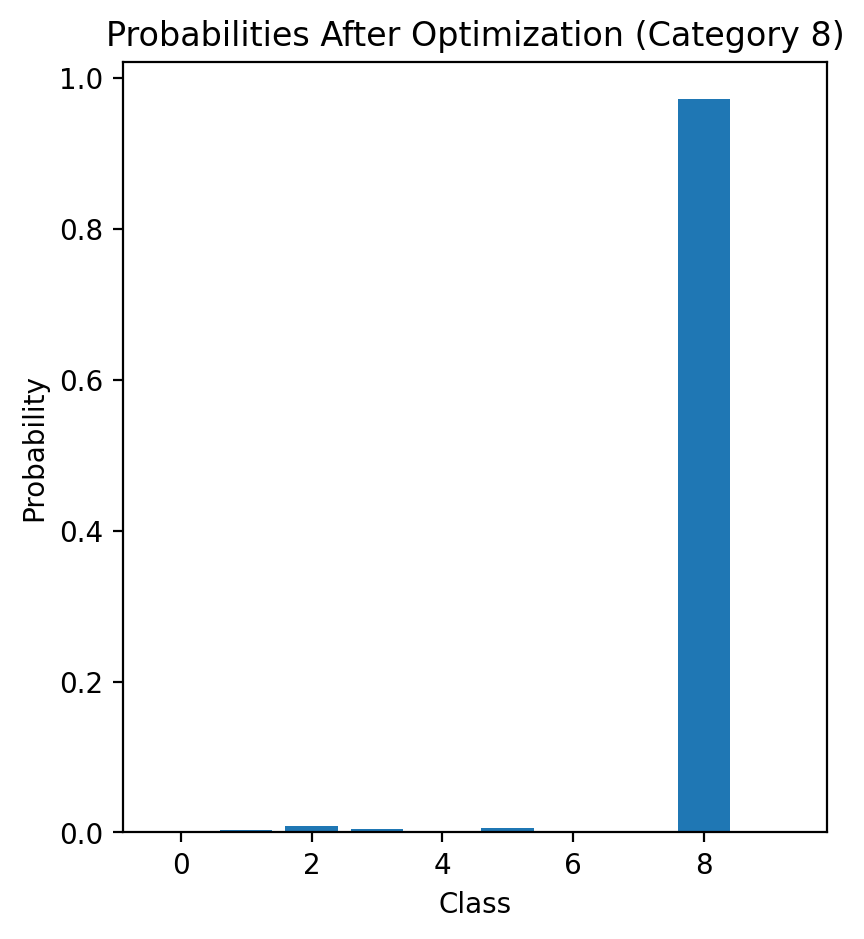

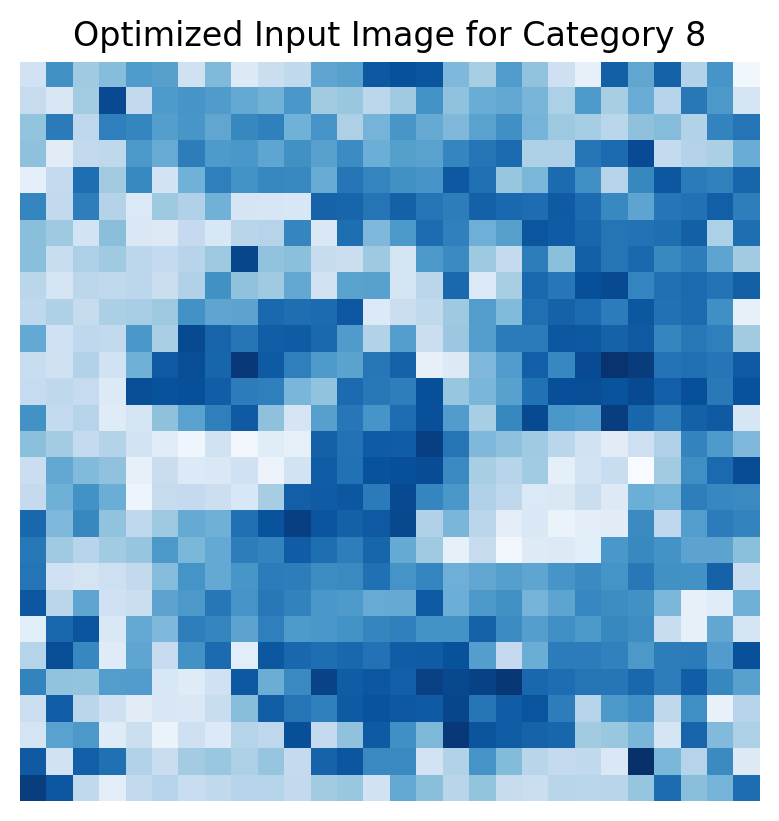

Finished optimization for category 8


Optimizing for category 9...
Probabilities before optimization for category 9:
tensor([[0.0725, 0.1024, 0.0766, 0.0702, 0.1582, 0.1347, 0.0670, 0.1672, 0.0553,
         0.0960]], grad_fn=<ExpBackward0>)


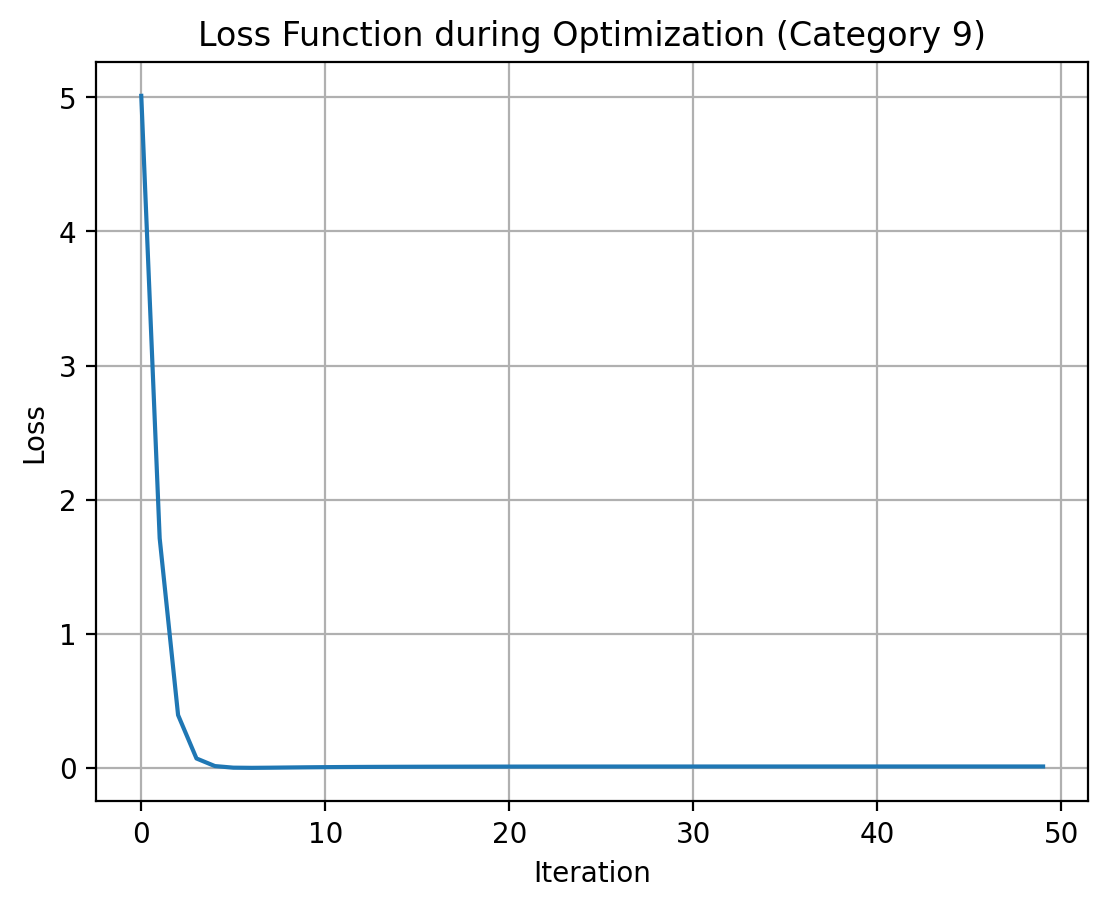

Probabilities after optimization for category 9:
tensor([[1.0289e-05, 2.7251e-05, 4.0845e-06, 9.2167e-04, 1.8577e-03, 3.0820e-04,
         4.9800e-07, 9.1156e-04, 2.2705e-04, 9.9573e-01]])


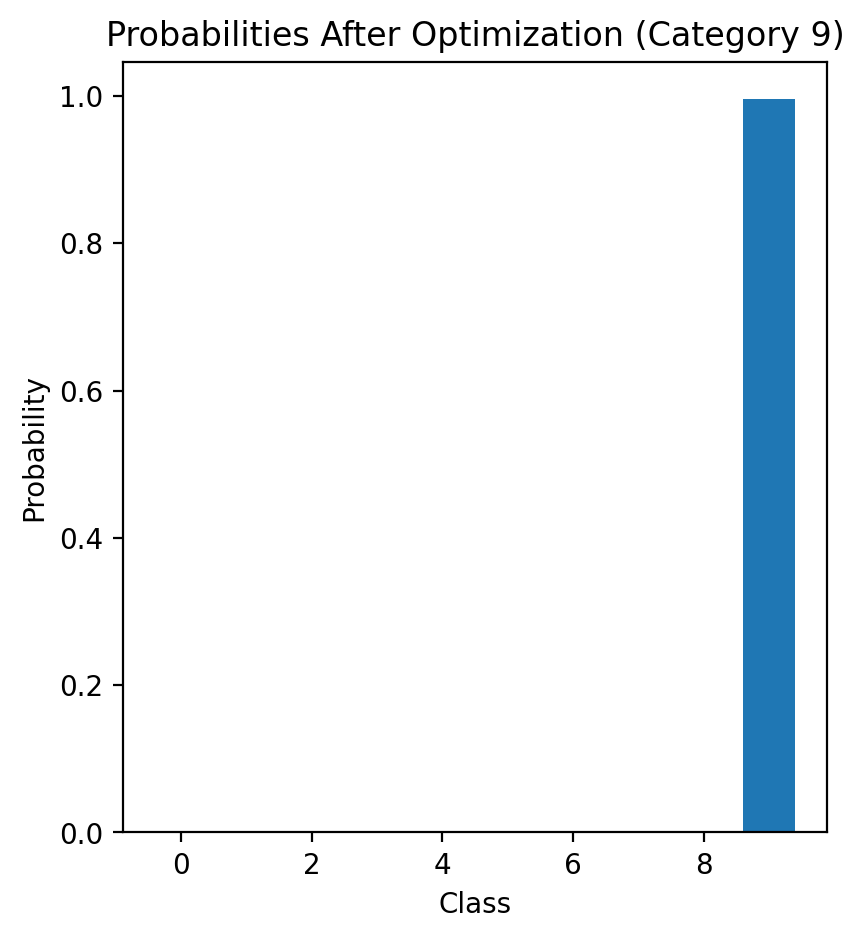

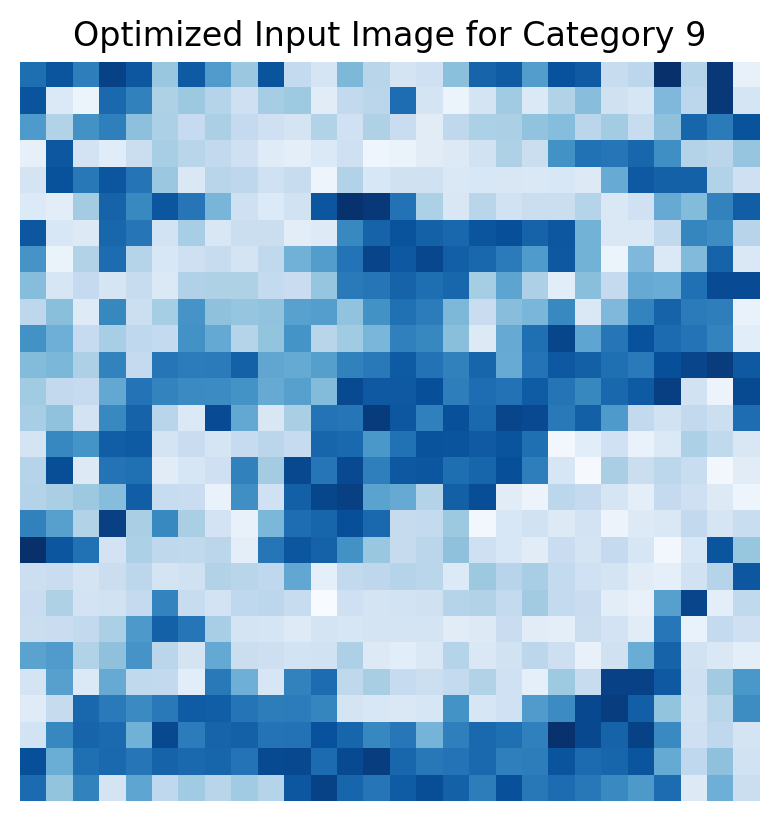

Finished optimization for category 9




In [21]:
#YOUR CODE HERE
for category in range(10):  # Itera sobre las categorías de 0 a 9
    print(f"Optimizing for category {category}...")

    # Paso 1: Inicializar el input de la red
    opt_input = Optimize_NN_Input(NN_trained=my_MLPdrop_extended, lr=5e-3, img0=torch.randn(28, 28)*0.01)
    
    # Paso 2: Calcular probabilidades antes de la optimización
    logprobs = opt_input.forward()
    probs = torch.exp(logprobs)
    print(f"Probabilities before optimization for category {category}:")
    print(probs)
    
    # Paso 3: Entrenamiento/Optimización para la categoría actual
    opt_input.trainloop(category=category, true_prob=torch.tensor(0.9), sgd_iter=50)
    
    # Paso 4: Graficar la pérdida durante el entrenamiento
    plt.plot([loss.item() for loss in opt_input.loss_during_training], label=f'Training Loss (Category {category})')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.title(f'Loss Function during Optimization (Category {category})')
    plt.grid(True)
    plt.show()
    
    # Paso 5: Calcular probabilidades después de la optimización
    logprobs_after = opt_input.forward()
    probs_after = torch.exp(logprobs_after).detach()
    print(f"Probabilities after optimization for category {category}:")
    print(probs_after)
    
    # Paso 6: Graficar las probabilidades antes y después de la optimización
    plt.figure(figsize=(10, 5))
    
    # Probabilidades después de la optimización
    plt.subplot(1, 2, 2)
    plt.bar(range(probs_after.shape[1]), probs_after.squeeze().cpu().numpy())
    plt.xlabel('Class')
    plt.ylabel('Probability')
    plt.title(f'Probabilities After Optimization (Category {category})')
    
    plt.show()
    
    # Paso 7: Graficar la imagen optimizada
    optimized_image = opt_input.input.detach().reshape(28, 28).cpu().numpy()
    
    plt.figure()
    plt.imshow(optimized_image, cmap='Blues')
    plt.title(f'Optimized Input Image for Category {category}')
    plt.axis('off')
    plt.show()

    print(f"Finished optimization for category {category}\n\n")
